## Imports

In [1]:
from system_prompts_builder import generate_all_permutations, CounselorPersonality
from questionnaires import get_prompt_eval_questionnaire, get_prompt_eval_questionnaire_partial_conv
import textwrap
import os
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from datasets import Dataset
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
import seaborn as sns
# import DPOConfig


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print("cuda version:", torch.version.cuda)

Using device: cpu
cuda version: 11.8


## Load Tokenizer

In [ ]:
from huggingface_hub import notebook_login

# log in to the Hugging Face hub (required for private datasets/models)
notebook_login()

In [3]:
therapist_model_id = "meta-llama/Llama-2-7b-hf"

# Load tokenizer 
#########################
tokenizer = AutoTokenizer.from_pretrained(therapist_model_id, trust_remote_code=True, device_map="auto")
# set the chat template to include <|im_start|> and <|im_end|> tokens
tokenizer.chat_template = "{% if not add_generation_prompt is defined %}{% set add_generation_prompt = false %}{% endif %}{% for message in messages %}{{'<|im_start|>' + message['role'] + '\n' + message['content'] + '<|im_end|>' + '\n'}}{% endfor %}{% if add_generation_prompt %}{{ '<|im_start|>assistant\n' }}{% endif %}"


# # add the <|im_start|> and <|im_end|> tokens to the tokenizer vocab and set them as the bos and eos tokens
# tokenizer.add_tokens(['<|im_start|>', '<|im_end|>'])
# tokenizer.bos_token = '<|im_start|>'
# tokenizer.eos_token = '<|im_end|>'


tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"  # Fix weird overflow issue with fp16 training
#########################

## Helper Functions to Load and process the data

In [4]:
# Method to Convert string representations of lists to actual lists
def convert_string_to_list(df):
    df["messages"] = df["messages"].apply(ast.literal_eval)
    df["conversation"] = df["conversation"].apply(ast.literal_eval)
    df["winning_scores_list"] = df["winning_scores_list"].apply(ast.literal_eval)
    df["losing_scores_list"] = df["losing_scores_list"].apply(ast.literal_eval)
    df["winning_scores_avg_list"] = df["winning_scores_avg_list"].apply(ast.literal_eval)
    df["losing_scores_avg_list"] = df["losing_scores_avg_list"].apply(ast.literal_eval)
    return df

# Method to load the preference trees
def load_preference_trees(data_path, start_index=0, end_index=96):
    preference_trees_list = []
    for i in range(start_index, end_index):
        with open(os.path.join(data_path, f"pref_data_{i}.csv"), "r") as f:
            pref_tree = pd.read_csv(f)
            pref_tree["tree_index"] = i
            preference_trees_list.append(pref_tree)
    # Concatenate all the preference trees into a single dataframe
    preference_trees_df = pd.concat(preference_trees_list, ignore_index=True)
    num_of_rows_before = preference_trees_df.shape[0]
    #get only rows with NaN values
    preference_trees_NaN = preference_trees_df[preference_trees_df.isna().any(axis=1)]
    # Drop rows with missing values
    preference_trees_df = preference_trees_df.dropna()
    num_of_rows_after = preference_trees_df.shape[0]
    num_rows_removed = num_of_rows_before - num_of_rows_after
    # Convert string representations of lists to actual lists
    preference_trees_df = convert_string_to_list(preference_trees_df)
    return preference_trees_df, preference_trees_list, num_rows_removed, preference_trees_NaN

# Method to add prompts column to the dataframe (aplly chat tamplet to the messages)
def add_prompts_column(df, tokenizer):
    prompt_list = [tokenizer.apply_chat_template(message, add_generation_prompt=True, tokenize=False) for message in df["messages"]]
    df["prompt"] = prompt_list
    return df

# Method to add prompt length column to the dataframe
def add_prompt_length_column(df, tokenizer):
    prompt_length_list = [len(tokenizer.encode(prompt)) for prompt in df["prompt"]]
    df["prompt_length"] = prompt_length_list
    return df

# Method to add conversation length (number of turns) column to the dataframe
def add_conversation_length_column(df):
    conversation_length_list = [len(conversation) for conversation in df["conversation"]]
    df["conversation_length"] = conversation_length_list
    return df

# Method to add eos token to the end of the responses
def add_end_token_to_responses(df, tokenizer):
    df["winning_response"] = [response + tokenizer.eos_token for response in df["winning_response"]]
    df["losing_response"] = [response + tokenizer.eos_token for response in df["losing_response"]]
    return df

# Method to remove rows where the winning response is the same as the losing response
def remove_duplicate_responses(df):
    df_without_duplicates = df[df["winning_response"] != df["losing_response"]]
    df_with_duplicates = df[df["winning_response"] == df["losing_response"]]
    return df_without_duplicates, df_with_duplicates

# Method to create the dpo_prefernce_data (Dict with keys: "prompt", "chosen", "rejected")
def create_preference_data(preference_trees_df, score_threshold=0.2,
                           prompt_column_name="prompt", winning_response_column_name="winning_response", losing_response_column_name="losing_response", 
                           winning_score_column_name="winning_score_final", losing_score_column_name="losing_score_final", min_score=0.0, max_score=5.0):
    # update the number of rows before dropping rows not within the min_score and max_score
    num_of_rows_before = preference_trees_df.shape[0]
    # drop rows where the winning score or losing score is less than min_score or greater than max_score
    preference_trees_df = preference_trees_df[(preference_trees_df[winning_score_column_name] >= min_score) & (preference_trees_df[winning_score_column_name] <= max_score)]
    preference_trees_df = preference_trees_df[(preference_trees_df[losing_score_column_name] >= min_score) & (preference_trees_df[losing_score_column_name] <= max_score)]
    # print the number of rows before and after dropping rows not within the min_score and max_score
    print(f"Number of rows in total: {num_of_rows_before}")
    print(f"Number of rows removed due to min_score or max_score: {num_of_rows_before - preference_trees_df.shape[0]}")
    print(f"Number of rows remaining: {preference_trees_df.shape[0]}")

    # update the number of rows before thresholding
    num_of_rows_before = preference_trees_df.shape[0] 
    # drop rows where the winning score < losing score + threshold
    preference_data = preference_trees_df[preference_trees_df[winning_score_column_name] >= preference_trees_df[losing_score_column_name] + score_threshold]
    num_of_rows_after = preference_data.shape[0]
    # print the number of rows before and after thresholding
    print(f"Number of rows in total: {num_of_rows_before}")
    print(f"Number of rows removed due to threshold: {num_of_rows_before - num_of_rows_after}")
    print(f"Number of rows remaining: {num_of_rows_after}")

    # Create the dpo_dataset_dict (Preference Data) (Dict with keys: "prompt", "chosen", "rejected")
    dpo_dataset_dict = {
    "prompt": preference_data[prompt_column_name].tolist(),
    "chosen": preference_data[winning_response_column_name].tolist(),
    "rejected": preference_data[losing_response_column_name].tolist(),
    }
    # Create the dpo_dataset from the dpo_dataset_dict
    dpo_dataset = Dataset.from_dict(dpo_dataset_dict)
    
    return dpo_dataset, preference_data

# Method to print the conversation with word wrapping
def print_conversation(conversation, max_width=80):
    """
    Print the conversation with word wrapping.

    Parameters:
        - conversation: A list of strings representing the conversation. (Therapist and Patient messages alternately, starting with the Therapist)
        - max_width: The maximum width for word wrapping. Default is 80.
    """
    for i, message in enumerate(conversation):
        role = "[THERAPIST]" if i % 2 == 0 else "[PATIENT]"
        print(f"{role}: \n{textwrap.fill(message, width=max_width)} \n")

# Method to get only the final conversations for each tree index
def get_df_for_final_conversations_for_each_tree_index(df):
    final_conversations_list = []
    for tree_index in df["tree_index"].unique():
        final_conversations = df[(df["tree_index"] == tree_index) & (df["conversation_length"] == df[df["tree_index"] == tree_index]["conversation_length"].max())]
        final_conversations_list.append(final_conversations)
    final_conversations_df = pd.concat(final_conversations_list, ignore_index=True)
    return final_conversations_df


## Load and Process the Data

In [5]:
######################### Lookahead=0 PartialEval #########################
# data_path = "LLM_DATA/Conversation_Trees/PartialEval_ET0.1_MT1.2_1-5_V.1.0" # PartialEval M-Tempeture=1.2, E-Temperature=0.1, score 1-5
# data_path = "LLM_DATA/Conversation_Trees/PartialEval_ET0.1_MT1.2_1-5_V.2.0" # PartialEval M-Tempeture=1.2, E-Temperature=0.1, score 1-5
# data_path = "LLM_DATA/Conversation_Trees/PartialEval_ET0.1_MT1.2_1-5_V.3.0" # PartialEval M-Tempeture=1.2, E-Temperature=0.1, score 1-5

# ########################## LookAhead5 PartialEval #########################
# data_path = "LLM_DATA/Conversation_Trees/PartialEval_LookAhead5_ET0.1_MT1.2_1-5_V.1.0" # PartialEval LokAhead5 M-Tempeture=1.2, E-Temperature=0.1, score 1-5
# data_path = "LLM_DATA/Conversation_Trees/PartialEval_LookAhead5_ET0.1_MT1.2_1-5_V.2.0" # PartialEval LokAhead5 M-Tempeture=1.2, E-Temperature=0.1, score 1-5

# ########################## LookAhead5 FulllEval #########################
# data_path = "LLM_DATA/Conversation_Trees/FullEval_LookAhead5_TTree1.2_TT0.7_TP0.7_TE0.1_V1.0"
# data_path = "LLM_DATA/Conversation_Trees/FullEval_LookAhead5_TTree1.2_TT0.7_TP0.7_TE0.1_V2.0"
# data_path = "LLM_DATA/Conversation_Trees/FullEval_LookAhead5_TTree1.2_TT0.7_TP0.7_TE0.1_V3.0"
# data_path = "LLM_DATA/Conversation_Trees/FullEval_LookAhead5_TTree1.2_TT0.7_TP0.7_TE0.1_V4.0"

# ########################## LookAhead5 NEW FulllEval #########################
# data_path = "LLM_DATA/Conversation_Trees/LookAhead5_FullEval_TTree1.4_TLoop0.7_TEval0.2_V1.0"
# data_path = "LLM_DATA/Conversation_Trees/LookAhead5_FullEval_TTree1.4_TLoop0.7_TEval0.2_V2.0"

# ########################## LookAhead3 FulllEval #########################
# data_path = "LLM_DATA/Conversation_Trees/LookAhead3_FullEval_TTree1.4_TLoop0.7_TEval0.2_V1.0" # 668 samples
# data_path = "LLM_DATA/Conversation_Trees/LookAhead3_FullEval_TTree1.4_TLoop0.7_TEval0.2_V2.0" # 705 samples
# data_path = "LLM_DATA/Conversation_Trees/LookAhead3_FullEval_TTree1.4_TLoop0.7_TEval0.2_V3.0" # 682 samples
# data_path = "LLM_DATA/Conversation_Trees/LookAhead3_FullEval_TTree1.4_TLoop0.7_TEval0.2_V4.0" # 716 samples

############################################################################################################################################
######################################################## NEW EXPERIMENTS ####################################################################
######################################################## NEW EXPERIMENTS ####################################################################
############################################################################################################################################
data_path = "LLM_DATA/Conversation_Trees/LookAhead_0/TTree1.4_TT0.9_TP0.7_TE0.2_V3"






# Load the preference trees
preference_trees_df, preference_trees_list, num_rows_removed, preference_trees_NaN = load_preference_trees(data_path=data_path, start_index=0, end_index=96)
print(f"Number of rows removed do to missing values: {num_rows_removed}, Number of rows remaining: {preference_trees_df.shape[0]}, Number of trees: {len(preference_trees_list)}, Number of trees in the dataframe: {preference_trees_df['tree_index'].nunique()}")

# Add prompts column to the dataframe (apply chat tamplet to the messages)
preference_trees_df = add_prompts_column(preference_trees_df, tokenizer)
preference_trees_df = add_prompt_length_column(preference_trees_df, tokenizer)
# preference_trees_df = add_end_token_to_responses(preference_trees_df, tokenizer)
preference_trees_df = add_conversation_length_column(preference_trees_df)
preference_trees_df, duplicate_responses_df = remove_duplicate_responses(preference_trees_df)
print(f"Number of duplicate responses removed: {duplicate_responses_df.shape[0]}")
final_conversations_df = get_df_for_final_conversations_for_each_tree_index(preference_trees_df)

#display(duplicate_responses_df.head())
# Create the preference data for the model
dpo_dataset, preference_trees_df = create_preference_data(preference_trees_df, score_threshold=0.1)
# print(f"Number of samples in the dataset: {dpo_dataset.num_rows}")
print("missing trees:", set(range(96)) - set(preference_trees_df["tree_index"].unique()))
# display(preference_trees_df.head())

Number of rows removed do to missing values: 0, Number of rows remaining: 1497, Number of trees: 96, Number of trees in the dataframe: 96
Number of duplicate responses removed: 3
Number of rows in total: 1494
Number of rows removed due to min_score or max_score: 2
Number of rows remaining: 1492
Number of rows in total: 1492
Number of rows removed due to threshold: 454
Number of rows remaining: 1038
missing trees: set()


In [6]:
# display(final_conversations_df.head())

In [7]:
# display(preference_trees_NaN)

In [8]:
# # show some examples of winning and losing responses with there final scores and the conversation length
# display(preference_trees_df[["prompt", "winning_response", "losing_response", "winning_score_final", "losing_score_final", "conversation_length"]].head())

# display(preference_trees_df.describe())

## Helper Functions for Plotting and Evaluation

In [9]:
def plot_prompt_length_distribution(ax, df, bins=20, density=True):
    print("max prompt length:", df["prompt_length"].max())
    print("min prompt length:", df["prompt_length"].min())
    print("mean prompt length:", df["prompt_length"].mean())
    ax.hist(df["prompt_length"], bins=bins, density=density, alpha=0.6, color='b')
    # add mean line
    ax.axvline(df["prompt_length"].mean(), color='k', linestyle='dashed', linewidth=1)
    ax.set_title("Distribution of the Prompt Lengths")
    ax.set_xlabel("Prompt Length")
    ax.set_ylabel("Frequency")

def plot_conversation_length_distribution(ax, df, bins=20, density=True):
    ax.hist(df["conversation_length"], bins=bins, density=density, alpha=0.6, color='g')
    # add mean line
    ax.axvline(df["conversation_length"].mean(), color='k', linestyle='dashed', linewidth=1)
    ax.set_title("Distribution of the Conversation Lengths")
    ax.set_xlabel("Number of Messages")
    ax.set_ylabel("Frequency")

def plot_score_distribution(ax, df, bins=20, density=True):
    print("mean winning score:", df["winning_score_final"].mean())
    print("mean losing score:", df["losing_score_final"].mean())
    ax.hist(df["winning_score_final"], bins=bins, density=density, alpha=0.6, color='blue', label="Winning Scores")
    ax.hist(df["losing_score_final"], bins=bins, density=density, alpha=0.6, color='red', label="Losing Scores")
    # add mean line
    ax.axvline(df["winning_score_final"].mean(), color='blue', linestyle='dashed', linewidth=1)
    ax.axvline(df["losing_score_final"].mean(), color='red', linestyle='dashed', linewidth=1)
    ax.set_title("Distribution of the Winning and Losing Scores")
    ax.set_xlabel("Scores")
    ax.set_ylabel("Frequency")
    ax.legend()

def plot_scores_vs_conversation_lengths(ax, df):
    offset = 0.2  # Horizontal offset to separate the winning and losing scores
    sns.scatterplot(ax=ax, x=df["conversation_length"] - offset, y=df["winning_score_final"], color="blue", label="Winning Scores")
    sns.scatterplot(ax=ax, x=df["conversation_length"] + offset, y=df["losing_score_final"], color="red", label="Losing Scores")
    ax.set_title("Scores vs Conversation Lengths with Offset")
    ax.set_xlabel("Conversation Lengths")
    ax.set_ylabel("Scores")
    ax.legend()

def plot_avg_scores_vs_conversation_lengths_with_variance(ax, df):
    conversation_lengths = df["conversation_length"].unique()
    offset = 0.1  # Horizontal offset to separate the error bars
    for length in conversation_lengths:
        subset_df = df[df["conversation_length"] == length]
        avg_winning_scores = subset_df["winning_score_final"].mean()# /2
        avg_losing_scores = subset_df["losing_score_final"].mean()# /2
        var_winning_scores = subset_df["winning_score_final"].var()# /4
        var_losing_scores = subset_df["losing_score_final"].var()# /4
        ax.errorbar(length - offset, avg_winning_scores, yerr=var_winning_scores, fmt='o', color="blue", label='Winning Scores' if length == conversation_lengths[0] else "")
        ax.errorbar(length + offset, avg_losing_scores, yerr=var_losing_scores, fmt='o', color="red", label='Losing Scores' if length == conversation_lengths[0] else "")
    ax.set_title("Average Scores vs Conversation Lengths with Variance")
    ax.set_xlabel("Conversation Lengths")
    ax.set_ylabel("Average Scores")
    ax.legend()

def plot_score_difference_distribution(ax, df, bins=20, density=True):
    ax.hist(df["winning_score_final"] - df["losing_score_final"], bins=bins, density=density, alpha=0.6, color='purple')
    # add mean line
    ax.axvline((df["winning_score_final"] - df["losing_score_final"]).mean(), color='k', linestyle='dashed', linewidth=1)
    ax.set_title("Distribution of the Winning and Losing Scores Difference")
    ax.set_xlabel("Scores Difference")
    ax.set_ylabel("Frequency")

def plot_response_length_distribution(ax, df, tokenizer, bins=20, density=True):
    ax.hist(df["winning_response"].apply(tokenizer.encode).apply(len), bins=bins, density=density, alpha=0.6, color="blue", label="Winning Response Lengths")
    ax.hist(df["losing_response"].apply(tokenizer.encode).apply(len), bins=bins, density=density, alpha=0.6, color="red", label="Losing Response Lengths")
    # add mean line
    ax.axvline(df["winning_response"].apply(tokenizer.encode).apply(len).mean(), color='blue', linestyle='dashed', linewidth=1)
    ax.axvline(df["losing_response"].apply(tokenizer.encode).apply(len).mean(), color='red', linestyle='dashed', linewidth=1)
    ax.set_title("Distribution of the Winning and Losing Response Lengths")
    ax.set_xlabel("Response Length")
    ax.set_ylabel("Frequency")
    ax.legend()

def plot_response_length_difference_distribution(ax, df, tokenizer, bins=20, density=True):
    ax.hist(df["winning_response"].apply(tokenizer.encode).apply(len) - df["losing_response"].apply(tokenizer.encode).apply(len), bins=bins, density=density, alpha=0.6, color='orange')
    # add mean line
    ax.axvline((df["winning_response"].apply(tokenizer.encode).apply(len) - df["losing_response"].apply(tokenizer.encode).apply(len)).mean(), color='k', linestyle='dashed', linewidth=1)
    ax.set_title("Distribution of the Winning and Losing Response Lengths Difference")
    ax.set_xlabel("Response Length Difference")
    ax.set_ylabel("Frequency")

#########################

## Plots

LLM_DATA/Conversation_Trees/LookAhead_0/TTree1.4_TT0.9_TP0.7_TE0.2_V3
Dataset Size: 1038
max prompt length: 4043
min prompt length: 290
mean prompt length: 1347.922928709056


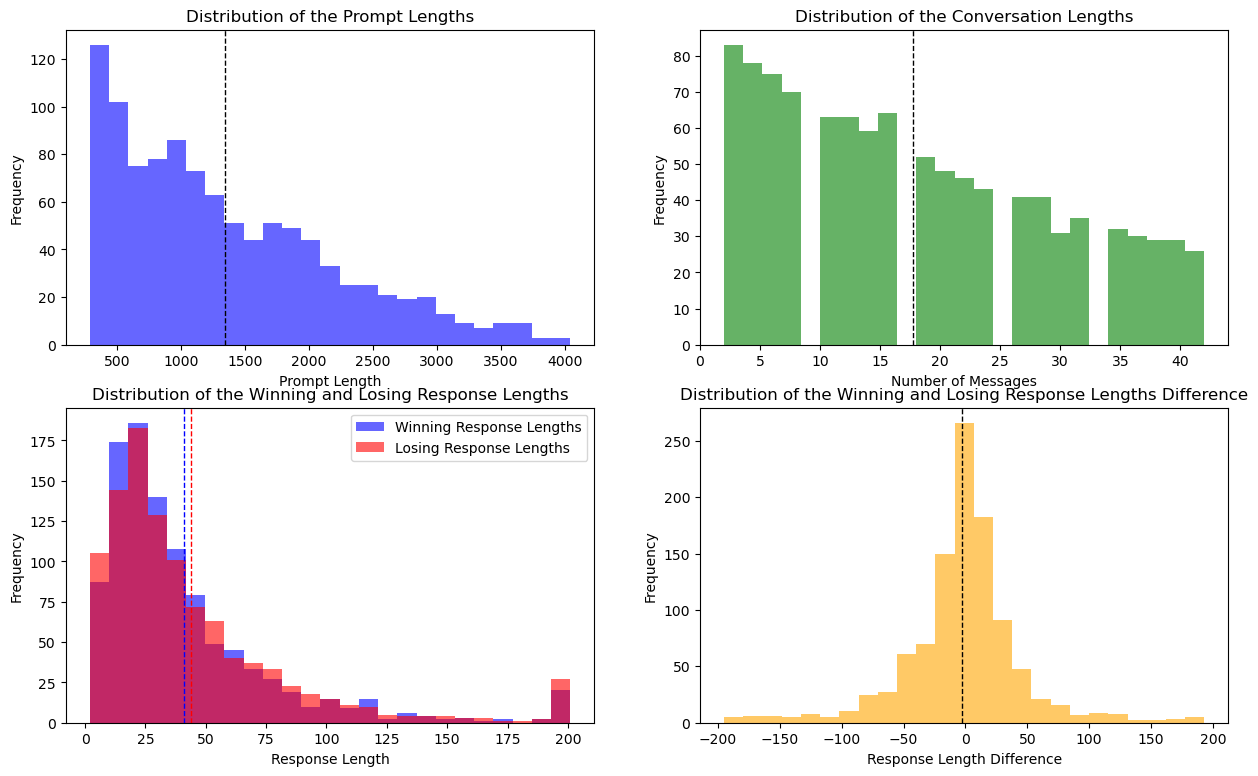

In [10]:
print(data_path)
# Creating subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 9))

# You can adjust the bins value as needed
bins_value = 25
density = False

print("Dataset Size:", preference_trees_df.shape[0])

# First row
plot_prompt_length_distribution(axs[0, 0], preference_trees_df, bins=bins_value, density=density)
plot_conversation_length_distribution(axs[0, 1], preference_trees_df, bins=bins_value, density=density)

# Second row
plot_response_length_distribution(axs[1, 0], preference_trees_df, tokenizer, bins=bins_value, density=density)
plot_response_length_difference_distribution(axs[1, 1], preference_trees_df, tokenizer, bins=bins_value, density=density)





mean winning score: 3.5749348294230985
mean losing score: 3.225762212399411


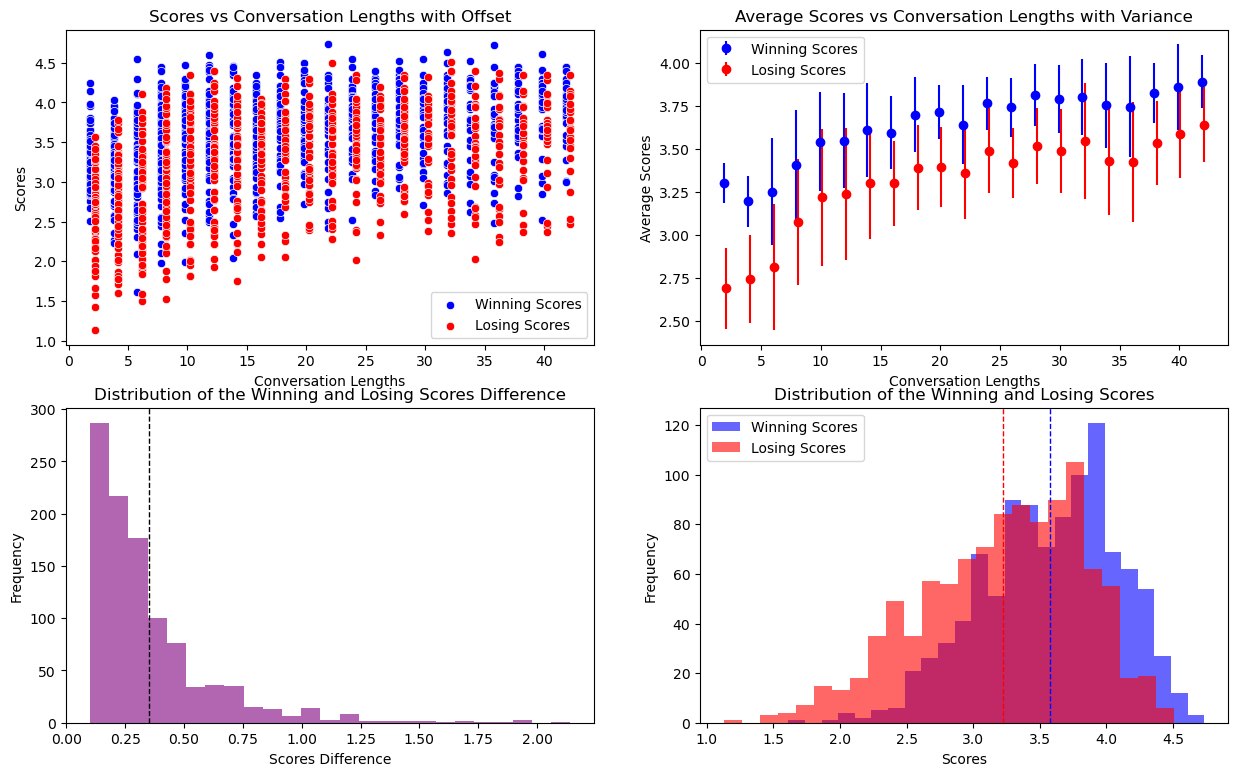

In [11]:
# Creating subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 9))

# You can adjust the bins value as needed
bins_value = 25
density = False

# Third row
plot_scores_vs_conversation_lengths(axs[0, 0], preference_trees_df)
plot_avg_scores_vs_conversation_lengths_with_variance(axs[0, 1], preference_trees_df)

# Fourth row
plot_score_difference_distribution(axs[1, 0], preference_trees_df, bins=bins_value, density=density)
plot_score_distribution(axs[1, 1], preference_trees_df, bins=bins_value, density=density)

In [12]:
# print some info and examples from final_conversations_df
print("Final Conversations Dataframe:")
conv_index = 0
print(final_conversations_df.iloc[conv_index].keys())

Final Conversations Dataframe:
Index(['conversation', 'messages', 'winning_response', 'losing_response',
       'winning_scores_list', 'losing_scores_list', 'winning_scores_avg_list',
       'losing_scores_avg_list', 'winning_score_final', 'losing_score_final',
       'winning_conversation', 'losing_conversation', 'tree_index', 'prompt',
       'prompt_length', 'conversation_length'],
      dtype='object')


In [13]:
index = 5
# keep only conversations with length = 50
#final_conversations_df = final_conversations_df[final_conversations_df["conversation_length"] == 50]
conversation = final_conversations_df.iloc[index]["conversation"]
conversation_length = final_conversations_df.iloc[index]["conversation_length"]
winning_response = final_conversations_df.iloc[index]["winning_response"]
losing_response = final_conversations_df.iloc[index]["losing_response"]
winning_score = final_conversations_df.iloc[index]["winning_score_final"]
losing_score = final_conversations_df.iloc[index]["losing_score_final"]
print(f"final_conversations_df shape: {final_conversations_df.shape}")
print(f"Conversation Index: {index}")
print_conversation(conversation)
print(f"Conversation Length: {conversation_length}")
print(f"Winning Response: {winning_response}")
print(f"Losing Response: {losing_response}")
print(f"Winning Score: {winning_score}")
print(f"Losing Score: {losing_score}")


final_conversations_df shape: (96, 16)
Conversation Index: 5
[THERAPIST]: 
My name is David, and I'm a counselor, can you start by telling me a little bit
about yourself and why you are here? 

[PATIENT]: 
Well, my name is James, I'm 61 years old, and I've been smoking for many years.
Lately, I've been increasingly concerned about the impact of smoking on my
health. I've never tried to quit before, but I know I need to do something about
it now. 

[THERAPIST]: 
Do you want me to introduce the intervention process with you right now? Do you
want to take this process step-by-step or in steps, or is the conversation now
okay for you to take the lead? 

[PATIENT]: 
I think I'm ready to jump into the intervention process. Let's take it step-by-
step. What do I need to do first? 

[THERAPIST]: 
Fine. I would like you to tell me your thoughts around the topic now. 

[PATIENT]: 
I feel like smoking has been a significant part of my life for so long that it's
hard to imagine not doing it. But a